In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import *
import shap

In [2]:
incidents_initial = pd.read_csv('data/cleaned_data.csv', sep = None, dtype={'YEAR OCCURRED': np.int_, 'MONTH OCCURRED': np.int_,'GEO CODE': np.str_, 'CRIME CATEGORY DESCRIPTION': np.str_,}, engine = 'python')

In [3]:
# uncomment to filter categories to be the first n most common
# counts = incidents_initial['CRIME CATEGORY DESCRIPTION'].value_counts()
# first_n = 1
# low_cats = counts.index[first_n:]
# incidents_filtered = incidents_initial
# for cat in low_cats:
#     incidents_filtered = incidents_filtered[incidents_filtered['CRIME CATEGORY DESCRIPTION'] != cat]

In [4]:
incidents_filtered = incidents_initial

# uncomment to filter by a specific category

# single_category = 'Missing Person'
# incidents_filtered = incidents_filtered[incidents_filtered['CRIME CATEGORY DESCRIPTION'] == single_category]
# incidents_filtered

In [5]:
incidents = incidents_filtered.drop(columns=['LATITUDE', 'LONGITUDE'])
# incidents = incidents_initial
#uncomment the line below to exclude traffic offenses from data
# incidents = incidents_initial[incidents_initial['CRIME CATEGORY DESCRIPTION'] != 'Traffic Offenses']

#only want the more urgent crimes
max_mins = 60

incidents = incidents[incidents['RESPONSE TIME'] >0]
incidents = incidents[incidents['RESPONSE TIME'] <= max_mins]

incidents = incidents.dropna()
print('There are',len(incidents),'entries')
y = incidents['RESPONSE TIME']
X = incidents.drop(columns=['RESPONSE TIME'])
X = X.loc[:, ~X.columns.str.contains('^Unnamed')]
# y.value_counts()

There are 200282 entries


In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7)

In [7]:
categorical_features_indices = [0,7]

In [8]:
model=CatBoostRegressor(iterations=50, depth=10, learning_rate=0.1, loss_function='RMSE', od_type = 'Iter')
# model=CatBoostRegressor()

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=False, verbose=False)

In [9]:
from sklearn.metrics import r2_score
pred = model.predict(X_validation)
rmse = (np.sqrt(mean_squared_error(y_validation, pred)))
r2 = r2_score(y_validation, pred)

In [10]:
rmse


8.85272463458722

In [11]:
error = pd.DataFrame()
error['Predicted'] = pred
error['Actual'] = y_validation.values

length = len(error)
ind =  [[]] * length
for i in range(length):
    ind[i] = i
error = error.sort_values(by=['Actual'])

# uncomment to plot model performance

# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.scatter(ind, error['Predicted'], s=1, c='b', marker="s", label='Predicted')
# ax1.scatter(ind, error['Actual'], s=1, c='r', marker="s", label='Actual')
# plt.legend(loc='upper left');
# plt.show()
# error.hist(column='Predicted', bins=max_mins)
# error.hist(column='Actual', bins=max_mins)

In [12]:

shap_values = model.get_feature_importance(Pool(X_validation, label=y_validation,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()


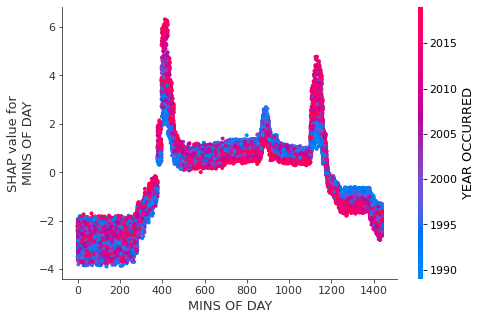

In [13]:
shap.initjs()
#police response time by time of day
shap.dependence_plot("MINS OF DAY", shap_values, X_validation, x_jitter=1)


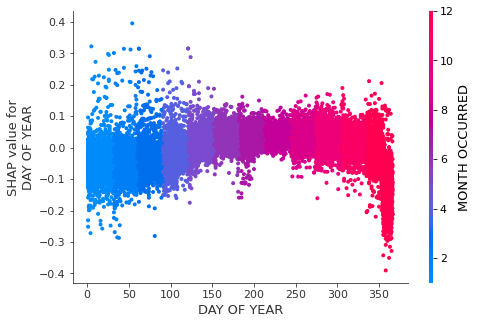

In [14]:
shap.dependence_plot("DAY OF YEAR", shap_values, X_validation, interaction_index="MONTH OCCURRED",show=False)


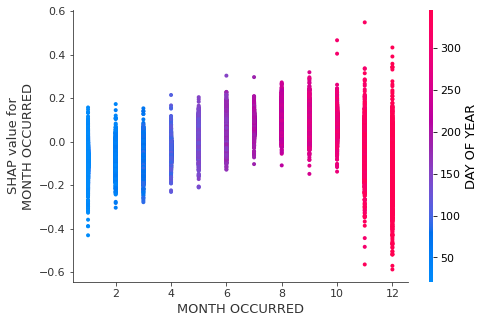

In [15]:
shap.dependence_plot("MONTH OCCURRED", shap_values, X_validation, interaction_index="DAY OF YEAR",show=False)


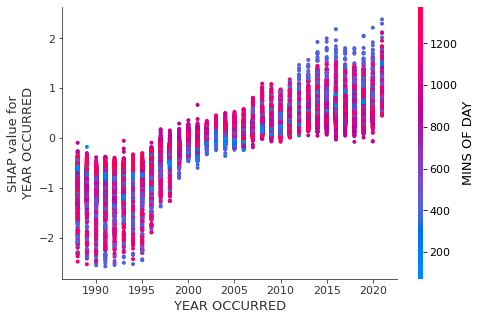

In [16]:
shap.dependence_plot("YEAR OCCURRED", shap_values, X_validation,show=False)


Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


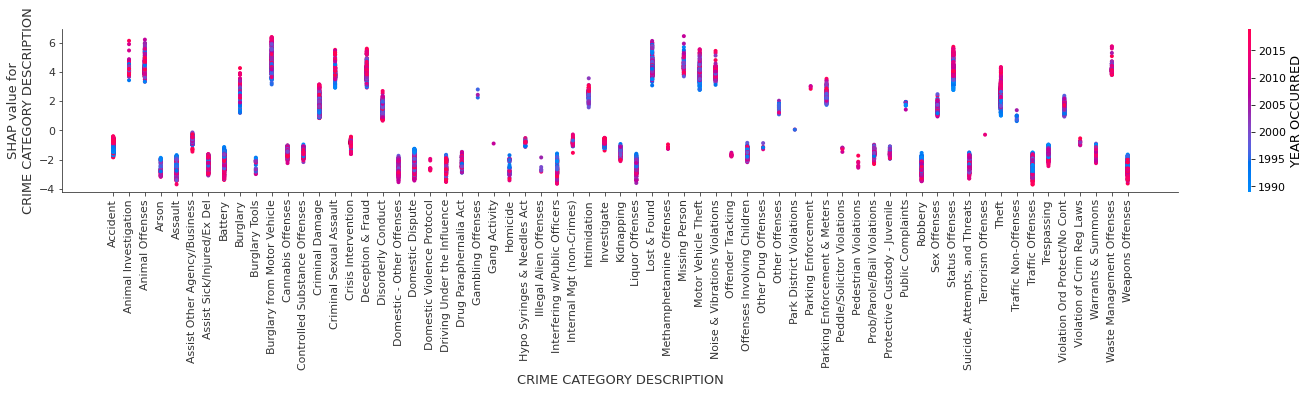

In [17]:
shap.initjs()


x = shap.dependence_plot("CRIME CATEGORY DESCRIPTION", shap_values, X_validation, interaction_index="YEAR OCCURRED",show=False)
fig = plt.gcf()
fig.set_size_inches(25, 3)
plt.savefig('shap-chart-crime-cat')

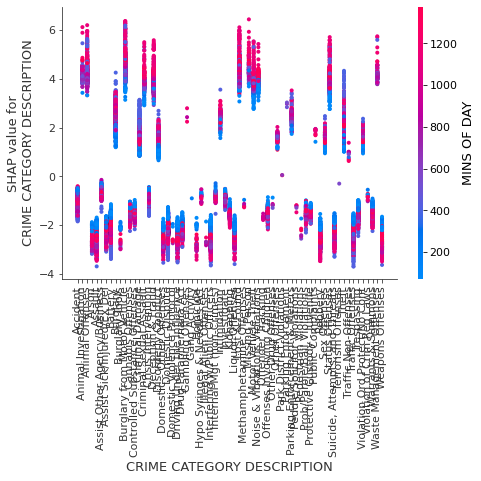

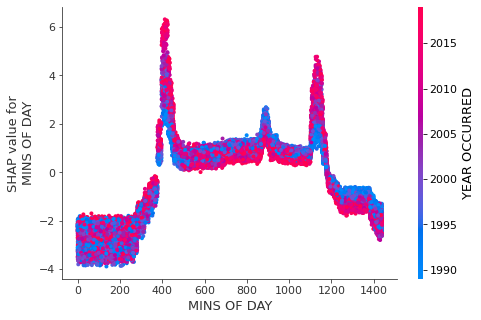

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


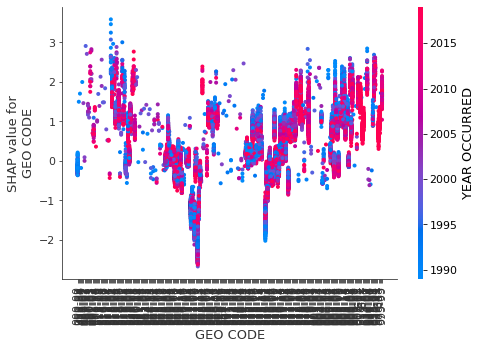

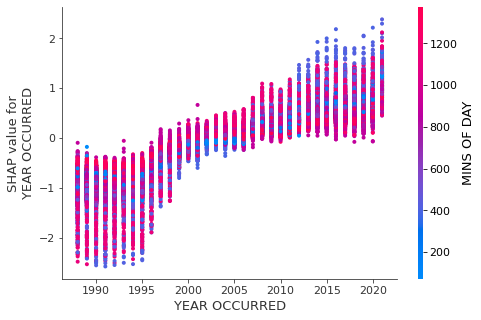

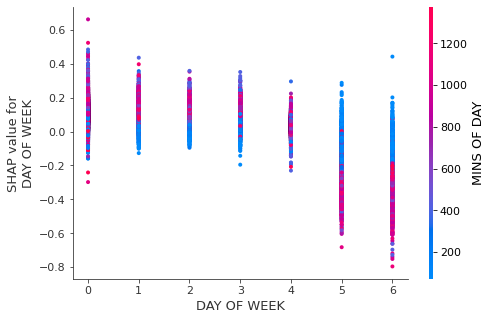

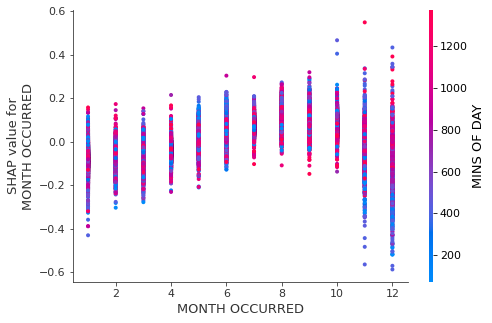

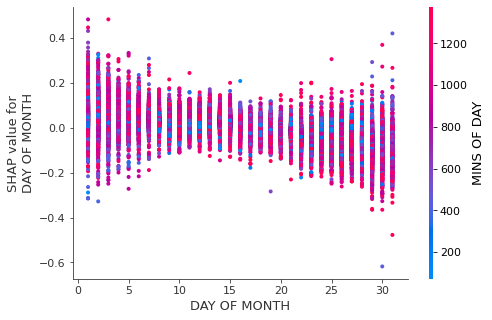

In [18]:
#show every dependece graph
for i in range(7):
    shap.dependence_plot("rank("+str(i)+")", shap_values, X_validation)

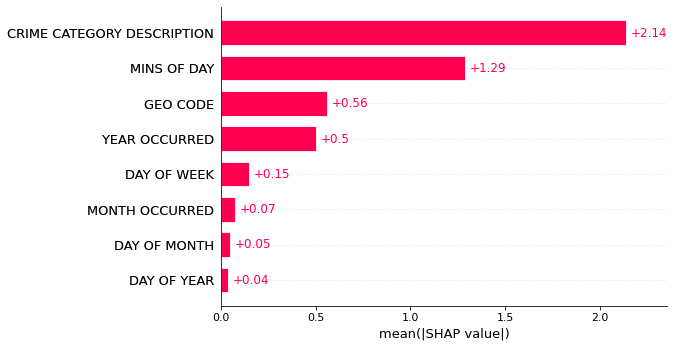

In [24]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.bar(shap_values)

In [25]:
# shap.plots.waterfall(shap_values[4])

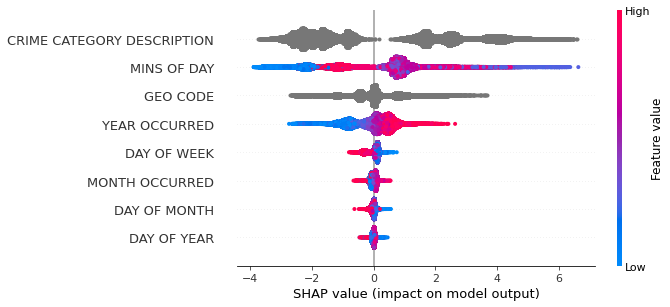

In [26]:
shap.plots.beeswarm(shap_values)

In [27]:
# shap.summary_plot(shap_values)

In [23]:
# uncomment to plot response time histograms by category

# cats = incidents_initial['CRIME CATEGORY DESCRIPTION'].unique()
# i = 0
# for c in cats:
#     i+=1
#     if i == 100:
#         break
#     a = incidents_initial[incidents_initial['CRIME CATEGORY DESCRIPTION'] == c]
#     print(c)
#     a.hist(column='RESPONSE TIME', bins=60)